#### Initialize

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objects as go

def create_plotly_template(
    title="",
    xaxis_title="",
    yaxis_title="",
    xrange=None,  # Tuple (min, max)
    yrange=None,  # Tuple (min, max)
    show_grid=True,
    grid_color="#EEEEEE",  # Light gray
    plot_bgcolor="white",
    paper_bgcolor="white",
    font_color="black",
    font_family="Arial",
    font_size=12,
    legend_orientation="v", # v for vertical, h for horizontal
    legend_x=None,          # Adjust legend position
    legend_y=None,
    **kwargs # Allows passing additional layout parameters
):
    """
    Creates a reusable Plotly graph template.

    Args
    -------------
        title: The title of the plot.
        xaxis_title: The title of the x-axis.
        yaxis_title: The title of the y-axis.
        xrange: Tuple defining the x-axis range (min, max).
        yrange: Tuple defining the y-axis range (min, max).
        show_grid: Whether to show grid lines.
        grid_color: Color of the grid lines.
        plot_bgcolor: Background color of the plotting area.
        paper_bgcolor: Background color of the entire figure.
        font_color: Color of the text.
        font_family: Font family for the text.
        font_size: Font size for the text.
        legend_orientation: Orientation of the legend ('v' for vertical, 'h' for horizontal).
        legend_x: x position of the legend.
        legend_y: y position of the legend.
        **kwargs: Additional keyword arguments to pass to the layout.

    Returns
    -------------
        A Plotly layout dictionary.
    """

    layout = go.Layout(
        title=dict(text=title, x=0.5),
        xaxis=dict(
            title=xaxis_title,
            range=xrange,
            showgrid=show_grid,
            gridcolor=grid_color,
            zeroline=False,  # Remove the zero line by default
        ),
        yaxis=dict(
            title=yaxis_title,
            range=yrange,
            showgrid=show_grid,
            gridcolor=grid_color,
            zeroline=False,
        ),
        plot_bgcolor=plot_bgcolor,
        paper_bgcolor=paper_bgcolor,
        font=dict(
            color=font_color,
            family=font_family,
            size=font_size,
        ),
        legend=dict(
            orientation=legend_orientation,
            x=legend_x,
            y=legend_y
        ),
        **kwargs  # Include additional layout parameters
    )
    return layout

Idea
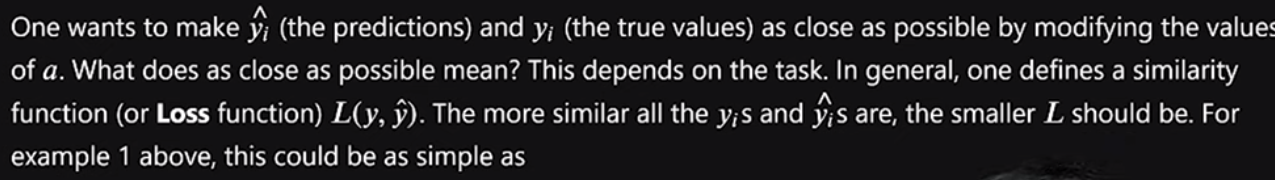
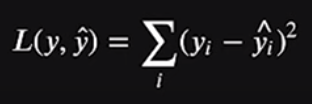

In [2]:
x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([[1,5,2,5]]).float()
print(f"x shape: {x.shape}")
print(f"y shape: {y.shape}")

x shape: torch.Size([4, 2])
y shape: torch.Size([1, 4])


Use of matrices `M1` and `M2` (~functions) such that the operation of matrices `M1` and `M2` on x, gives output that is as close to tensor y as possible. The weights of `M1` and `M2` constitute the weights of the parameters defined inside the matrices. 
Operation of `M1` on x = x*`M1`

In [3]:
# M1 = Vector - Takes 2 Dim Input and returns 8 Dimensional output 
# (Choice of 8 outputs is totally random, i.e. it can be changed to any other number)
# M2 = Vector - Takes 8 Dim Input and returns 1 Dimensional output
# Total no. of parameters = Parameters of Matrix M1 (16) + Parameters of Matrix M2 (8) = 24
M1 = nn.Linear(2,8,bias=False)
print(M1)
M1(x)

Linear(in_features=2, out_features=8, bias=False)


tensor([[-7.7782e-01,  2.4897e+00, -2.9192e+00,  1.6057e+00,  1.8834e+00,
          2.9666e+00,  7.9490e-01,  3.2792e+00],
        [-6.0219e-01,  1.9294e+00, -2.5005e+00,  1.4362e+00,  1.3583e+00,
          2.2987e+00,  7.9813e-01,  2.6639e+00],
        [ 2.3836e-01, -7.4757e-01, -1.0293e+00,  1.0528e+00, -1.3754e+00,
         -8.9369e-01,  1.2182e+00, -3.6886e-03],
        [-4.0146e-01,  1.3062e+00, -4.1520e+00,  2.9528e+00, -1.2553e-01,
          1.5524e+00,  2.4202e+00,  3.0691e+00]], grad_fn=<MmBackward0>)

In [4]:
M2 = nn.Linear(8,1,bias=False)
M2(M1(x)).squeeze()    # squeeze() eliminates the dimension 1 (similar to np.ravel in numpy)

tensor([ 0.6947,  0.5496, -0.1183,  0.4886], grad_fn=<SqueezeBackward0>)

#### Constructing the neural network (With Activation Function 'R')

Ver1 : Base Model + NO Activation Function

In [5]:
# Construction the network using nn.Module allows the parameters to be conveniently stored. 
# This will be useful later when we need to adjust them.

class MyNeuralNet1(nn.Module):
    """Neural Network with 2 layers and without activation function.
    """
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
    def forward(self,x):
        x = self.Matrix2(self.Matrix1(x))
        return x.squeeze()

def train_model(x, y, f, n_epochs=50):
    opt = SGD(f.parameters(), lr=1e-3)
    L = nn.MSELoss()

    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()   # flush previous epoch's gradient
        loss_value = L(f(x).reshape(1,4), y)    # compute loss
        loss_value.backward()      # compute gradient
        opt.step()                 # perform iteration using gradient above
        losses.append(loss_value.item())

    return f, losses

x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([[1,5,2,5]]).float()
f = MyNeuralNet1()
f1, losses = train_model(x, y, f, n_epochs=5000)
losses1 = losses

print(f"Desired Output: {y}")
print(f"Predicted Output: {f1(x)}")

Desired Output: tensor([[1., 5., 2., 5.]])
Predicted Output: tensor([2.7776, 2.4993, 1.9397, 5.2712], grad_fn=<SqueezeBackward0>)


Ver2 : Base Model + Activation Function

In [6]:
# Demonstration of Activation Function
# R = Activation Function (Allows only positive values to pass through. 
# Negative values are converted to 0)
z = torch.tensor([[1,2,-5,0], 
                  [4, -11, 11, 10]])
R = nn.ReLU()
R(z)

tensor([[ 1,  2,  0,  0],
        [ 4,  0, 11, 10]])

In [7]:
class MyNeuralNet2(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,8,bias=False)
        self.Matrix2 = nn.Linear(8,1,bias=False)
        self.R = nn.ReLU()       
    def forward(self,x):
        x = self.Matrix2(self.R(self.Matrix1(x)))
        return x.squeeze()
    
def train_model(x, y, f, n_epochs=50):
    opt = SGD(f.parameters(), lr=1e-3)
    L = nn.MSELoss()

    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()   # flush previous epoch's gradient
        loss_value = L(f(x).reshape(1,4), y)    # compute loss
        loss_value.backward()      # compute gradient
        opt.step()                 # perform iteration using gradient above
        losses.append(loss_value.item())

    return f, losses

x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([[1,5,2,5]]).float()
f = MyNeuralNet2()
f2, losses = train_model(x, y, f, n_epochs=5000)
losses2 = losses

print(f"Desired Output: {y}")
print(f"Predicted Output: {f2(x)}")

Desired Output: tensor([[1., 5., 2., 5.]])
Predicted Output: tensor([2.7914, 2.5077, 1.9545, 5.2540], grad_fn=<SqueezeBackward0>)


Ver3 : Base Model + Activation Function + 80 Parameters in each matrix

In [8]:
class MyNeuralNet3(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80,bias=False)
        self.Matrix2 = nn.Linear(80,1,bias=False)
        self.R = nn.ReLU() # R = Activation Function
    def forward(self,x):
        x = self.Matrix2(self.R(self.Matrix1(x)))
        # x = self.Matrix2(x)
        return x.squeeze()
    
def train_model(x, y, f, n_epochs=50):
    opt = SGD(f.parameters(), lr=1e-3)
    L = nn.MSELoss()

    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()   # flush previous epoch's gradient
        loss_value = L(f(x).reshape(1,4), y)    # compute loss
        loss_value.backward()      # compute gradient
        opt.step()                 # perform iteration using gradient above
        losses.append(loss_value.item())

    return f, losses

x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([[1,5,2,5]]).float()
f = MyNeuralNet3()
f3, losses = train_model(x, y, f, n_epochs=5000)
losses3 = losses

print(f"Desired Output: {y}")
print(f"Predicted Output: {f3(x)}")

Desired Output: tensor([[1., 5., 2., 5.]])
Predicted Output: tensor([1.8368, 3.7639, 1.9089, 5.1514], grad_fn=<SqueezeBackward0>)


Ver4 : Base Model + Activation Function + 80 Parameters in each matrix + Bias Vector

In [9]:
class MyNeuralNet4(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80,bias=True)  
        self.Matrix2 = nn.Linear(80,1,bias=True)
        self.R = nn.ReLU() # R = Activation Function
    def forward(self,x):
        x = self.Matrix2(self.R(self.Matrix1(x)))
        # x = self.Matrix2(x)
        return x.squeeze()
    
def train_model(x, y, f, n_epochs=50):
    opt = SGD(f.parameters(), lr=1e-3)
    L = nn.MSELoss()

    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()   # flush previous epoch's gradient
        loss_value = L(f(x).reshape(1,4), y)    # compute loss
        loss_value.backward()      # compute gradient
        opt.step()                 # perform iteration using gradient above
        losses.append(loss_value.item())

    return f, losses

x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([[1,5,2,5]]).float()
f = MyNeuralNet4()
f4, losses = train_model(x, y, f, n_epochs=5000)
losses4 = losses

print(f"Desired Output: {y}")
print(f"Predicted Output: {f4(x)}")

Desired Output: tensor([[1., 5., 2., 5.]])
Predicted Output: tensor([1.3110, 4.5876, 2.0211, 5.0216], grad_fn=<SqueezeBackward0>)


Ver5 : Base Model + Activation Function + 80 Parameters in each matrix + Bias Vector + Additional Layer (Matrix3)

In [10]:
class MyNeuralNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.Matrix1 = nn.Linear(2,80,bias=True)    # bias = Constant addition after matrix multiplication
        self.Matrix2 = nn.Linear(80,80,bias=True) 
        self.Matrix3 = nn.Linear(80,1,bias=True)
        self.R = nn.ReLU()                          # R = Activation Function
    def forward(self,x):
        x = self.Matrix3(self.R(self.Matrix2(self.R(self.Matrix1(x)))))
        return x.squeeze()
    
def train_model(x, y, f, n_epochs=50):
    opt = SGD(f.parameters(), lr=1e-3)
    L = nn.MSELoss()

    losses = []
    for _ in range(n_epochs):
        opt.zero_grad()             # flush previous epoch's gradient
        y_hat = f(x).reshape(1,4)   # prediction from model
        loss_value = L(y_hat, y)    # compute loss
        loss_value.backward()       # compute gradient
        opt.step()                  # perform iteration using gradient above
        losses.append(loss_value.item())

    return f, losses

x = torch.tensor([[6,2], [5,2], [1,3], [7,6]]).float()
y = torch.tensor([[1,5,2,5]]).float()
f = MyNeuralNet5()
f5, losses = train_model(x, y, f, n_epochs=5000)
losses5 = losses

print(f"Desired Output: {y}")
print(f"Predicted Output: {f5(x)}")

Desired Output: tensor([[1., 5., 2., 5.]])
Predicted Output: tensor([0.9995, 4.9946, 1.9990, 4.9965], grad_fn=<SqueezeBackward0>)


Plot Lossses

In [11]:
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale
color_rgb = sample_colorscale('rainbow', 5)

fig = make_subplots()
for j, i in enumerate([losses1, losses2, losses3, losses4, losses5]):
    fig.add_scatter(x=list(range(len(i))), y=i, name=f'Ver{j+1}', marker=dict(color=color_rgb[j]))
fig.update_layout(create_plotly_template(
    title="Losses", xaxis_title="Epochs", yaxis_title="Loss", show_grid=False)
)
fig.show()

Comparison of Predictions

Desired Output: tensor([[1., 5., 2., 5.]])
Predicted Output: tensor([0.9995, 4.9946, 1.9990, 4.9965])


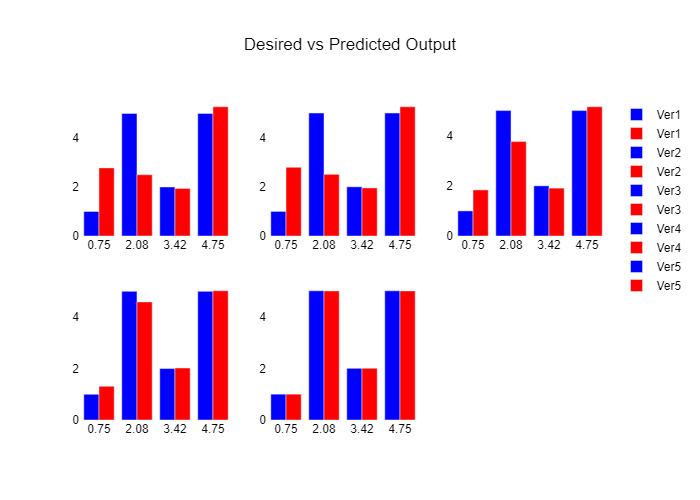

In [15]:
y_hat = f5(x).detach().float()
# fig1, ax1 = plt.subplots()
width=0.5
# ax1.bar(x=np.linspace(1,5,4)-width/2, height=y.squeeze(), color='b', width=width)
# ax1.bar(x=np.linspace(1,5,4)+width/2, height=y_hat, color='r', width=width)
print(f"Desired Output: {y}")
print(f"Predicted Output: {y_hat}")

fig = make_subplots(rows=2, cols=3)
fig.add_bar(x=np.linspace(1,5,4)-width/2, y=y.squeeze(), name='Ver1', marker=dict(color='blue'), row=1, col=1)
fig.add_bar(x=np.linspace(1,5,4)-width/2, y=f1(x).detach().float(), name='Ver1', marker=dict(color='red'), row=1, col=1)

fig.add_bar(x=np.linspace(1,5,4)-width/2, y=y.squeeze(), name='Ver2', marker=dict(color='blue'), row=1, col=2)
fig.add_bar(x=np.linspace(1,5,4)-width/2, y=f2(x).detach().float(), name='Ver2', marker=dict(color='red'), row=1, col=2)

fig.add_bar(x=np.linspace(1,5,4)-width/2, y=y.squeeze(), name='Ver3', marker=dict(color='blue'), row=1, col=3)
fig.add_bar(x=np.linspace(1,5,4)-width/2, y=f3(x).detach().float(), name='Ver3', marker=dict(color='red'), row=1, col=3)

fig.add_bar(x=np.linspace(1,5,4)-width/2, y=y.squeeze(), name='Ver4', marker=dict(color='blue'), row=2, col=1)
fig.add_bar(x=np.linspace(1,5,4)-width/2, y=f4(x).detach().float(), name='Ver4', marker=dict(color='red'), row=2, col=1)

fig.add_bar(x=np.linspace(1,5,4)-width/2, y=y.squeeze(), name='Ver5', marker=dict(color='blue'), row=2, col=2)
fig.add_bar(x=np.linspace(1,5,4)-width/2, y=f5(x).detach().float(), name='Ver5', marker=dict(color='red'), row=2, col=2)

fig.update_layout(create_plotly_template(show_grid=False, title='Desired vs Predicted Output')
)

# Show Plotly figure as a static image
import plotly.io as pio
from IPython.display import Image
pio.write_image(fig, 'plotly_figure.png')

# Display the static image
Image('plotly_figure.png')
# fig.show()